In [1]:
import hdf5plugin
import h5py    
import numpy as np  
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def print_all_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            print(prefix + key)  # Print the dataset name
        elif isinstance(item, h5py.Group):
            print_all_datasets(item, prefix + key + '/')  # Recursively explore groups
            
def list_datasets(group, prefix=''):
    for key in group.keys():
        item = group[key]
        if isinstance(item, pd.DataFrame):
            print(prefix + key)  # Print the dataset path
        elif isinstance(item, pd.io.pytables.HDFStore):
            list_datasets(item, prefix + key + '/')  # Recursively explore groups


default_colors = {0: 'green', 1: 'blue', 2: 'orange', 3: 'red'}
import matplotlib.pyplot as plt
import matplotlib

In [3]:
region_name = 'SLC5A12_regions'
celltype = 'enterocytes'
fold = 'fold_0'
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]

regions_df = pd.read_csv('region_scores/'+celltype+'/'+region_name+"/"+fold+".interpreted_regions.bed", sep='\t', names=NARROWPEAK_SCHEMA)

seq_length = 2114
regions_df['int_start'] = regions_df['start']+regions_df['summit']-seq_length/2
regions_df['int_end'] = regions_df['start']+regions_df['summit']+seq_length/2



In [4]:
def get_model_score(file_path,sequence_number):
    import h5py
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Access the dataset
        dataset = f['shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get contribution_scores
        df = pd.DataFrame(dataset[sequence_number][:])
    
        # Access the dataset
        dataset = f['raw']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df2 = pd.DataFrame(dataset[sequence_number][:])


        # Access the dataset
        dataset = f['projected_shap']['seq']
        
        # Convert dataset to a pandas DataFrame
        #get sequence
        df4 = pd.DataFrame(dataset[sequence_number][:])

    df3 = df*df2

    return(df2,df3)
        

In [5]:
model_head = 'profile' #either profile or counts

In [6]:
sequence_number = 0
sequence_chr,sequence_start,sequence_end = regions_df.loc[sequence_number,'chr'],int(regions_df.loc[sequence_number,'int_start']),int(regions_df.loc[sequence_number,'int_end'])
seq_list = []
folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:

    file_path = 'region_scores/'+celltype+'/SNC_SLC5A12_study/SNC_SLC5A12_study_extr_'+fold+"."+model_head+"_scores.h5"
    dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed

    seq,model_score_fold = get_model_score(file_path,sequence_number)
    seq_list.append(seq)
    if i == 0:
        model_score_sum = model_score_fold
        i+=1
    else:
        model_score_sum = model_score_sum + model_score_fold

model_score_avg_0 = model_score_sum/len(folds)

In [7]:
sequence_number = 1
seq_list = []
folds = ['fold_0','fold_1','fold_2','fold_3','fold_4']
i = 0
for fold in folds:
    try:
        file_path = 'region_scores/'+celltype+'/SNC_SLC5A12_study/SNC_SLC5A12_study_extr_'+fold+"."+model_head+"_scores.h5"
        dataset_key = '/projected_shap/seq'  # Adjust the dataset key as needed
    
        seq,model_score_fold = get_model_score(file_path,sequence_number)
        seq_list.append(seq)
        if i == 0:
            model_score_sum = model_score_fold
            i+=1
        else:
            model_score_sum = model_score_sum + model_score_fold
    except:
        print(fold)

model_score_avg_1 = model_score_sum/len(folds)

In [8]:
seq_df_0 = model_score_avg_0.T
seq_df_0.columns = ['A','C','G','T']

In [9]:
seq_df_1 = model_score_avg_1.T
seq_df_1.columns = ['A','C','G','T']

In [10]:

import numpy as np
# Generate a 100bp grid
grid = np.linspace(0, 2114, num=22)
# Round each grid value to the nearest multiple of 100
rounded_grid = np.round(grid / 100) * 100
# Add starting position
grid2 = [x+sequence_start for x in rounded_grid]
# Round to nearest multiple of 100
rounded_grid2 = np.round(np.array(grid2) / 100) * 100
rounded_grid2 = [int(x) for x in rounded_grid2]
#Reset locations
tick_locations = [x-sequence_start for x in rounded_grid2]
#Add chr to first tick
rounded_grid2 = [str(x) for x in rounded_grid2]
rounded_grid2[0] = sequence_chr+": " + str(rounded_grid2[0])

In [11]:
human_SNCs = pd.read_csv("extra_data/hg38_panTro6_SLC5A12i_divergent_site.tsv",sep="\t")
human_SNCs = human_SNCs.reset_index()
human_SNCs['ID'] = 'ID_'+human_SNCs['index'].astype('str')
human_SNCs['pos'] = human_SNCs['hg38_coor(1-based)'] - 26716894 - 1 #subtract int_start and 1

In [12]:
seq_df_1.loc[1176]

A    0.000000
C    0.000000
G    0.000000
T   -0.000014
Name: 1176, dtype: float16

In [13]:
seq_df_0.loc[1176]

A    0.000000
C    0.000000
G    0.000000
T    0.000228
Name: 1176, dtype: float16

In [14]:
seq_0 = np.abs(seq_df_0).T.idxmax()
seq_1 = np.abs(seq_df_1).T.idxmax()

In [15]:
snp_coords = np.where(seq_0!=seq_1)

In [16]:
snp_coords

(array([  20,   25,   28,   29,   30,   34,   71,  112,  938,  943, 1001,
        1018, 1102, 1151, 1157, 1160, 1187, 1230, 1265, 1282, 1965, 2004,
        2028, 2043, 2066, 2080, 2081]),)

In [17]:
SNP_pos = human_SNCs['pos']

In [18]:
dseq_snps = seq_df_0.loc[SNP_pos]-seq_df_1.loc[SNP_pos]

In [19]:
dseq_snps.T.sum().sort_values()

1018   -0.000499
1230   -0.000220
1151   -0.000197
1187   -0.000049
1265   -0.000030
1102   -0.000026
1157    0.000002
943     0.000108
1160    0.000239
1001    0.000282
1282    0.000335
938     0.000597
dtype: float16

In [20]:
region_name = 'SNC_SLC5A12_study'

In [21]:
model_scores = [model_score_avg_0,model_score_avg_1]

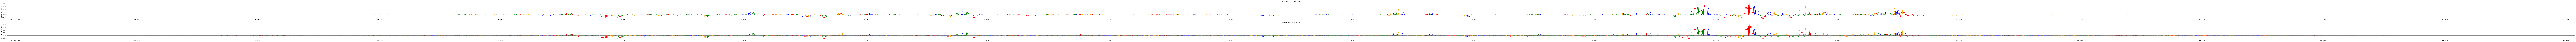

In [22]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np

# Assuming len_seq and celltypes are defined
len_seq = 2000
celltypes = ['enterocytes human region','enterocytes chimp region']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype,model_score_avg in zip(axes, celltypes,model_scores):
    ax.set_title(celltype)
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Display the plot
plt.tight_layout()
plt.savefig("region_plots/human_vs_chimp/"+region_name+"_"+str(sequence_number)+"_"+model_head+".pdf",bbox_inches='tight',pad_inches=0)
plt.show()


In [23]:
dseq_snps

,A,C,G,T
938,-0.000000,0.000585,0.000000,0.000012
943,-0.000193,0.000000,0.000301,0.000000
1001,0.000000,-0.000019,0.000301,0.000000
1018,0.000000,-0.000230,-0.000000,-0.000268
1102,0.000113,0.000000,-0.000139,0.000000
1151,-0.000188,0.000000,-0.000009,0.000000
1157,0.000154,0.000000,-0.000151,0.000000
1160,-0.000019,0.000000,0.000257,0.000000
1187,-0.000058,0.000009,-0.000000,0.000000
1230,0.000000,-0.000212,0.000000,-0.000008


In [24]:
min_pos = np.min(dseq_snps.index) - 20
max_pos = np.max(dseq_snps.index) + 20
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

385


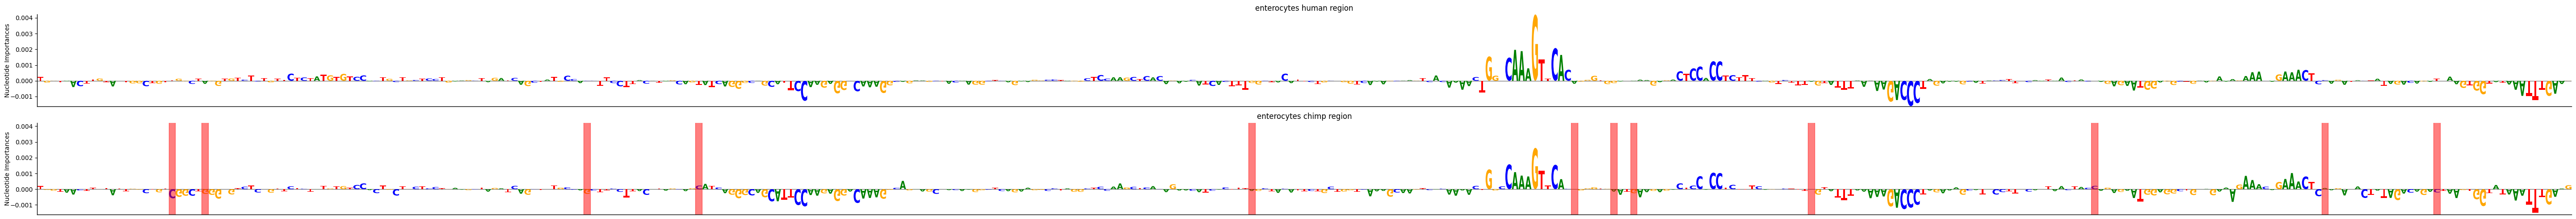

In [25]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.patches as patches

# Assuming len_seq and celltypes are defined
len_seq = len(seq_df_trimmed.index)
celltypes = ['enterocytes human region','enterocytes chimp region']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype,model_score_avg in zip(axes, celltypes,model_scores):
    ax.set_title(celltype)
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    seq_df = seq_df.loc[min_pos:max_pos]
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    #ax.set_xticks(ticks=tick_locations)
    #ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

for i in dseq_snps.index:
#   ax.text(i, -0.05, "S",
#            bbox={'fc':'green', 'pad':1,'alpha':0.2})
    # Define the position and dimensions of the box
    width = 1       # width of the box
    x_position = i - width/2 # x position for the box

    height = 1 # height of the box (can be adjusted as needed)
    opacity = 0.5   # opacity of the box
    
    # Create a rectangle patch
    rect = patches.Rectangle((x_position, -height/2), width, height, linewidth=1, edgecolor='r', facecolor='r', alpha=opacity)
    
    # Add the rectangle to the plot
    ax.add_patch(rect)

#for i, x_tick in enumerate(x_ticks[:-1]):
#    ax.text(x_tick+0.03, y_ticks[0]-0.165, "text %i"%i,
#            bbox={'fc':'green', 'pad':10})
    
# Display the plot
plt.tight_layout()
plt.savefig("region_plots/human_vs_chimp/"+region_name+"_"+str(sequence_number)+"_"+model_head+"_zoom_SNCs.pdf",bbox_inches='tight',pad_inches=0)
plt.show()


In [26]:
human_SNCs

,index,#chr,hg38_coor(1-based),Hg38,panTro6,ID,pos
0,0,chr11,26717833,T,C,ID_0,938
1,1,chr11,26717838,A,G,ID_1,943
2,2,chr11,26717896,C,G,ID_2,1001
3,3,chr11,26717913,T,C,ID_3,1018
4,4,chr11,26717997,G,A,ID_4,1102
5,5,chr11,26718046,A,G,ID_5,1151
6,6,chr11,26718052,G,A,ID_6,1157
7,7,chr11,26718055,A,G,ID_7,1160
8,8,chr11,26718082,A,C,ID_8,1187
9,9,chr11,26718125,T,C,ID_9,1230


In [27]:
min_pos = human_SNCs.loc[3,'pos'] - 20
max_pos = human_SNCs.loc[7,'pos'] + 20
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

183


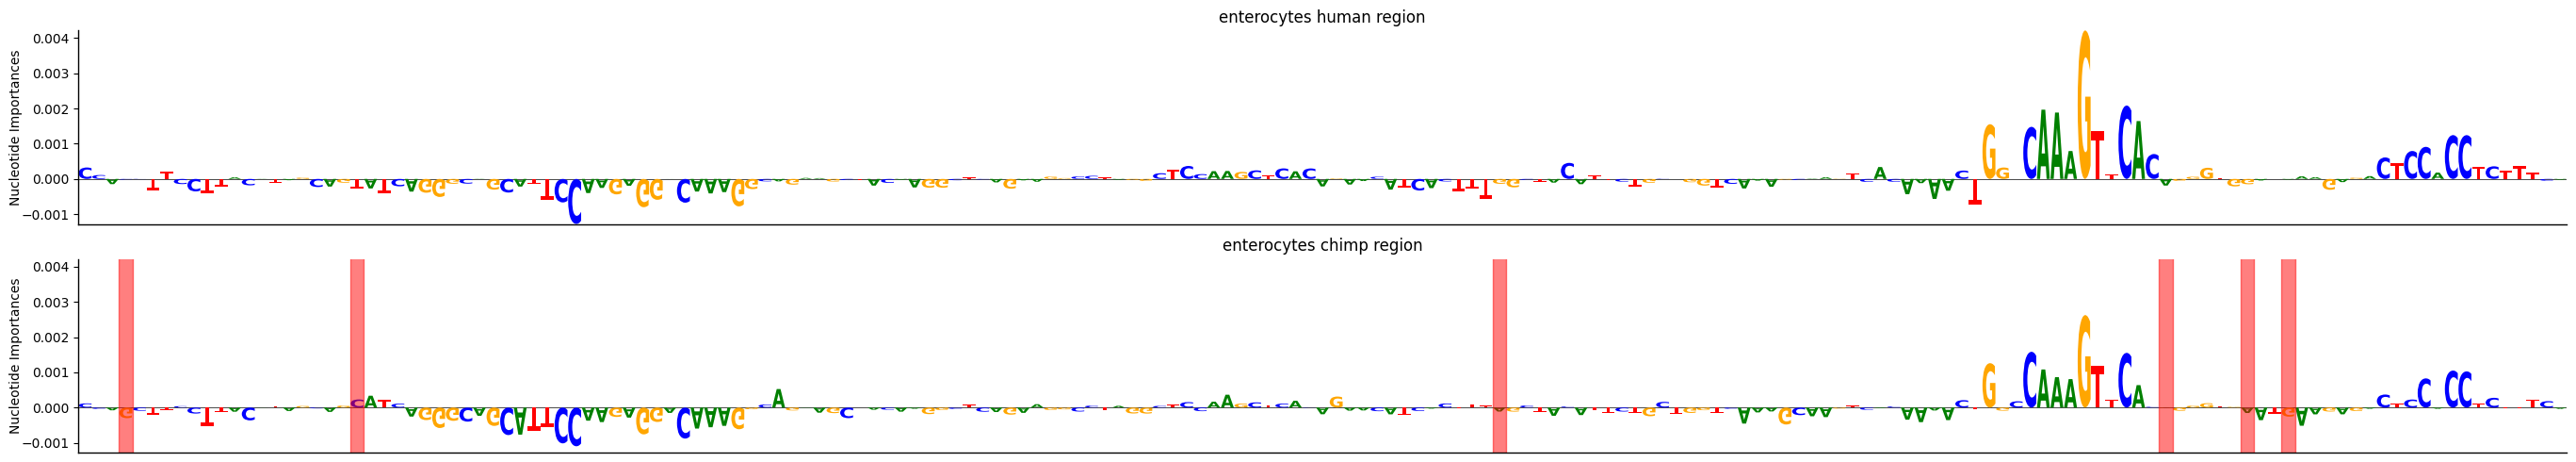

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.patches as patches

# Assuming len_seq and celltypes are defined
len_seq = len(seq_df_trimmed.index)
celltypes = ['enterocytes human region','enterocytes chimp region']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype,model_score_avg in zip(axes, celltypes,model_scores):
    ax.set_title(celltype)
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    seq_df = seq_df.loc[min_pos:max_pos]
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    #ax.set_xticks(ticks=tick_locations)
    #ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

for i in dseq_snps.index:
#   ax.text(i, -0.05, "S",
#            bbox={'fc':'green', 'pad':1,'alpha':0.2})
    # Define the position and dimensions of the box
    width = 1       # width of the box
    x_position = i - width/2 # x position for the box

    height = 1 # height of the box (can be adjusted as needed)
    opacity = 0.5   # opacity of the box
    
    # Create a rectangle patch
    rect = patches.Rectangle((x_position, -height/2), width, height, linewidth=1, edgecolor='r', facecolor='r', alpha=opacity)
    
    # Add the rectangle to the plot
    ax.add_patch(rect)

#for i, x_tick in enumerate(x_ticks[:-1]):
#    ax.text(x_tick+0.03, y_ticks[0]-0.165, "text %i"%i,
#            bbox={'fc':'green', 'pad':10})
    
# Display the plot
plt.tight_layout()
plt.savefig("region_plots/human_vs_chimp/"+region_name+"_"+str(sequence_number)+"_"+model_head+"_zoom_SNC_3-7.pdf",bbox_inches='tight',pad_inches=0)
plt.show()


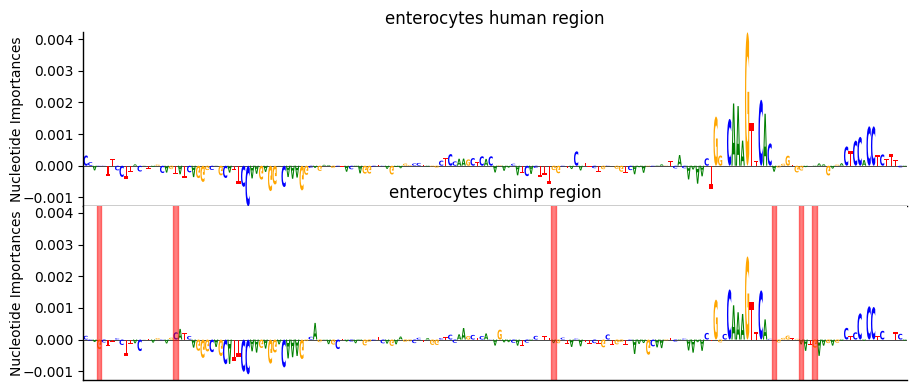

In [29]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.patches as patches

# Assuming len_seq and celltypes are defined
len_seq = len(seq_df_trimmed.index)
celltypes = ['enterocytes human region','enterocytes chimp region']

# Create a figure
fig = plt.figure(figsize=(100/2000*len_seq, 2*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig,hspace=0)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype,model_score_avg in zip(axes, celltypes,model_scores):
    ax.set_title(celltype)
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    seq_df = seq_df.loc[min_pos:max_pos]
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    #ax.set_xticks(ticks=tick_locations)
    #ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

for i in dseq_snps.index:
#   ax.text(i, -0.05, "S",
#            bbox={'fc':'green', 'pad':1,'alpha':0.2})
    # Define the position and dimensions of the box
    width = 1       # width of the box
    x_position = i - width/2 # x position for the box

    height = 1 # height of the box (can be adjusted as needed)
    opacity = 0.5   # opacity of the box
    
    # Create a rectangle patch
    rect = patches.Rectangle((x_position, -height/2), width, height, linewidth=1, edgecolor='r', facecolor='r', alpha=opacity)
    
    # Add the rectangle to the plot
    ax.add_patch(rect)

#for i, x_tick in enumerate(x_ticks[:-1]):
#    ax.text(x_tick+0.03, y_ticks[0]-0.165, "text %i"%i,
#            bbox={'fc':'green', 'pad':10})
    
# Display the plot
plt.tight_layout()
plt.savefig("region_plots/human_vs_chimp/"+region_name+"_"+str(sequence_number)+"_"+model_head+"_zoom_SNC_3-7_small.pdf",bbox_inches='tight',pad_inches=0)
plt.show()
plt.close()


In [30]:
model_score_avg

,0,1,2,3,4,5,6,7,8,9,...,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
min_pos = human_SNCs.loc[2,'pos'] - 30
max_pos = human_SNCs.loc[4,'pos'] + 50
print(max_pos-min_pos)

181


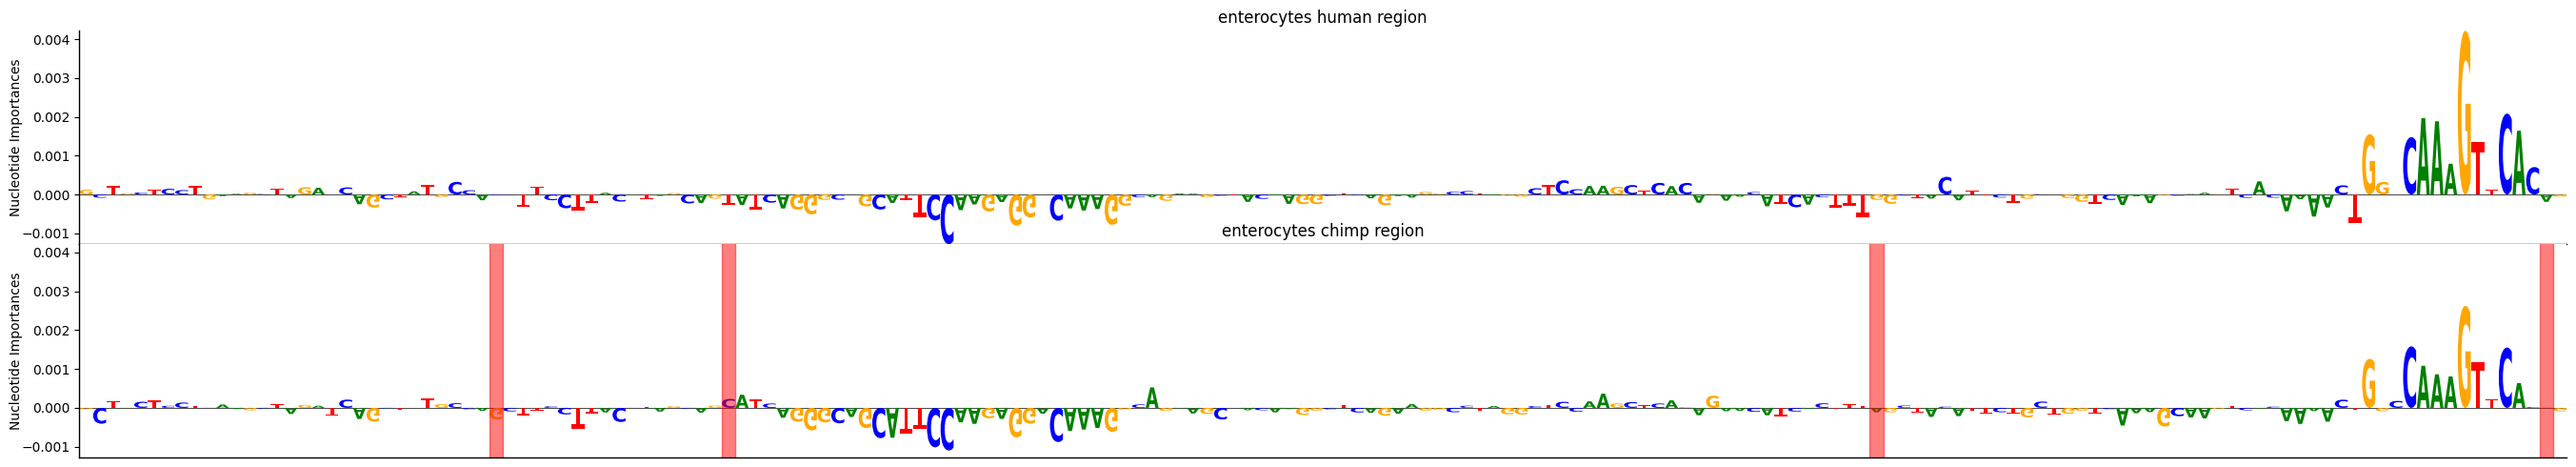

In [32]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.patches as patches

# Assuming len_seq and celltypes are defined
len_seq = max_pos-min_pos
celltypes = ['enterocytes human region','enterocytes chimp region']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig,hspace=0)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype,model_score_avg in zip(axes, celltypes,model_scores):
    ax.set_title(celltype)
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    seq_df = seq_df.loc[min_pos:max_pos]
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    #ax.set_xticks(ticks=tick_locations)
    #ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

for i in dseq_snps.index:
#   ax.text(i, -0.05, "S",
#            bbox={'fc':'green', 'pad':1,'alpha':0.2})
    # Define the position and dimensions of the box
    width = 1       # width of the box
    x_position = i - width/2 # x position for the box

    height = 1 # height of the box (can be adjusted as needed)
    opacity = 0.5   # opacity of the box
    
    # Create a rectangle patch
    rect = patches.Rectangle((x_position, -height/2), width, height, linewidth=1, edgecolor='r', facecolor='r', alpha=opacity)
    
    # Add the rectangle to the plot
    ax.add_patch(rect)

#for i, x_tick in enumerate(x_ticks[:-1]):
#    ax.text(x_tick+0.03, y_ticks[0]-0.165, "text %i"%i,
#            bbox={'fc':'green', 'pad':10})
    
# Display the plot
plt.tight_layout()
plt.savefig("region_plots/human_vs_chimp/"+region_name+"_"+str(sequence_number)+"_"+model_head+"_zoom_SNC_3-7_xsmall.pdf",bbox_inches='tight',pad_inches=0)
plt.show()


1018

In [26]:
max_contrib = np.abs(seq_df.T).max()
max_contrib_Z = (max_contrib-max_contrib.mean())/max_contrib.std()

In [27]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>5]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

337


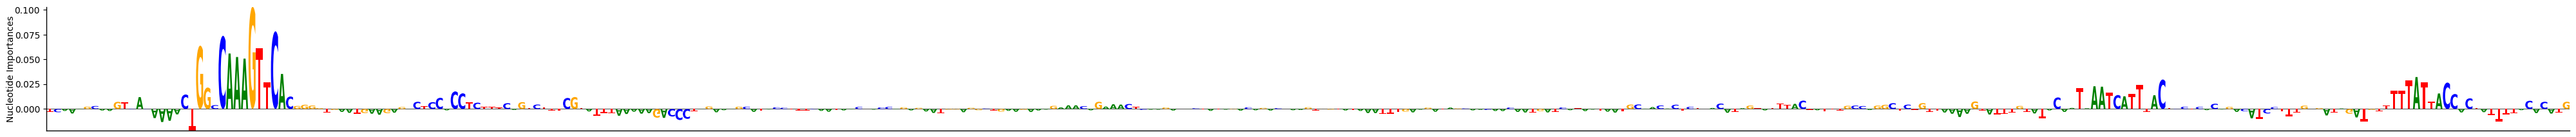

In [28]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [12]:
max_contrib_Z_thresh = max_contrib_Z[max_contrib_Z>5]
min_pos = np.array(max_contrib_Z_thresh.index).min()
max_pos = np.array(max_contrib_Z_thresh.index).max()

min_pos = np.max([min_pos - 20,1])
max_pos = np.min([max_pos+20,2000])
seq_df_trimmed = seq_df.loc[min_pos:max_pos,:]
print(len(seq_df_trimmed.index))

91


In [57]:
min_pos,max_pos

(976, 1066)

976

In [121]:
def plot_region_ISM(seq_df,ISM_df,highlight_SNP=None):

    

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    import logomaker
    import numpy as np

    base_colors = {}
    base_colors['A'] = 'g'
    base_colors['C'] = 'b'
    base_colors['G'] = 'gold'
    base_colors['T'] = 'r'

    # Assuming len_seq and celltypes are defined
    len_seq = len(seq_df.index)
    min_pos = np.min(seq_df_trimmed.index)
    max_pos = np.max(seq_df_trimmed.index)
    
    # Create a figure
    fig = plt.figure(figsize=(300/2000*len_seq,5))

    # Create a GridSpec with 1 column and rows equal to the number of cell types
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared y-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in [0,1]]

    ax = axes[0]
    ax.set_title(celltype)    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
#    crp_logo.ax.yaxis.set_ylabel('test')

    ax.set_ylabel("Nucleotide Importances",fontsize=10)

    ax1 = axes[1]
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)
    ax1.set_ylabel("$\Delta$ Log[counts]",fontsize=10)
    
    for base in ['A','G','T','C']:
        df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
    
        x,y = df_base['pos'],df_base['log_counts_diff_avg']
        ax1.scatter(x,y,c=base_colors[base])

    if highlight_SNP:
        snp_pos = highlight_SNP.keys()

        for pos in snp_pos:
            base = highlight_SNP[pos]
            df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()
            df_base = df_base.loc[df_base['pos']==pos]
            x,y = df_base['pos'],df_base['log_counts_diff_avg']
            ax1.scatter(x,y,c=base_colors[base],edgecolors='k',linewidths=2)      

    
    ax1.set_xlim([min_pos,max_pos])
    ax1.axhline(y=0,xmin=min_pos,xmax=max_pos,linewidth=2)

    plt.show()
    plt.close()
    

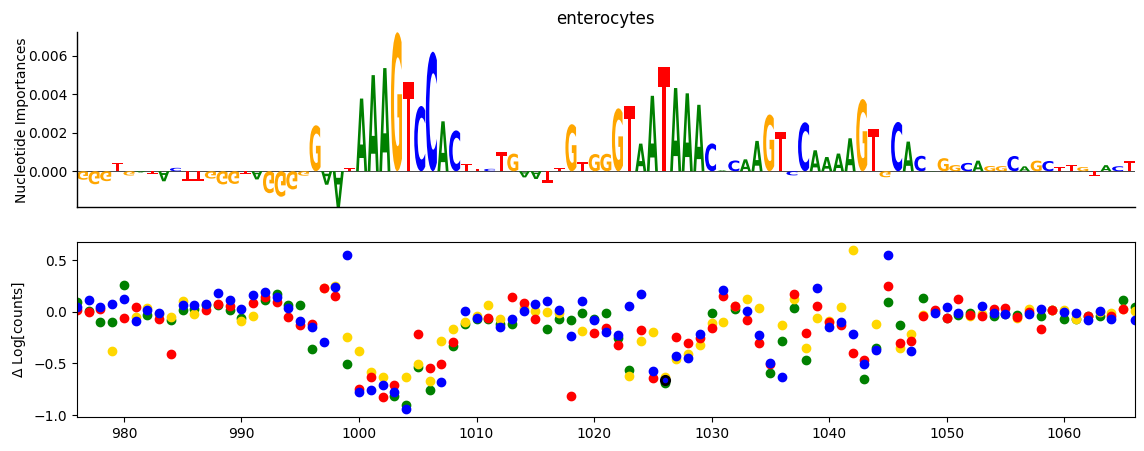

In [122]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP)

In [116]:
143119431-regions_df['int_start']

0    1026.0
Name: int_start, dtype: float64

In [117]:
regions_df

,chr,start,end,1,2,3,4,5,6,summit,int_start,int_end
0,chr6,143119078,143119909,human_peaks_peak_73844,405,.,7.64483,43.3045,40.5006,384,143118405.0,143120519.0


In [118]:
highlight_SNP = {}
highlight_SNP[1026] = 'C'

In [129]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib

def plot_region_ISM(seq_df, ISM_df, highlight_SNP=None, save_path=None):
    base_colors = {
        'A': 'g',
        'C': 'b',
        'G': 'gold',
        'T': 'r'
    }

    len_seq = len(seq_df)
    min_pos = np.min(seq_df.index)
    max_pos = np.max(seq_df.index)

    # Create a figure
    fig = plt.figure(figsize=(300 / 2000 * len_seq, 5))

    # Create a GridSpec with 2 rows and 1 column
    gs = gridspec.GridSpec(2, 1, figure=fig)

    # Create axes in each grid cell with shared x-axis
    axes = [fig.add_subplot(gs[i, 0]) for i in range(2)]

    # Plot the sequence logo
    ax = axes[0]
    crp_logo = logomaker.Logo(seq_df, shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)

    ax.set_ylabel("Nucleotide Importances", fontsize=10)

    # Plot the ISM data
    ax1 = axes[1]
    ax1.axhline(y=0, color='black', linewidth=1, linestyle='--')

    ax1.set_ylabel("$\Delta$ Log[counts]", fontsize=10)
    
    for base in ['A', 'G', 'T', 'C']:
        df_base = ISM_df[ISM_df['alt'] == base].copy()
        x, y = df_base['pos'], df_base['log_counts_diff_avg']
        ax1.scatter(x, y, c=base_colors[base], label=base)

    if highlight_SNP:
        for pos, base in highlight_SNP.items():
            df_base = ISM_df[(ISM_df['alt'] == base) & (ISM_df['pos'] == pos)]
            x, y = df_base['pos'], df_base['log_counts_diff_avg']
            ax1.scatter(x, y, c=base_colors[base], edgecolors='k', linewidths=2)

    ax1.set_xlim([min_pos, max_pos])

    # Adding legend to the second subplot
    ax1.legend()

    if save_path:
        plt.savefig(save_path,dpi=350,bbox_inches='tight',pad_inches=0)
    plt.show()
    plt.close()


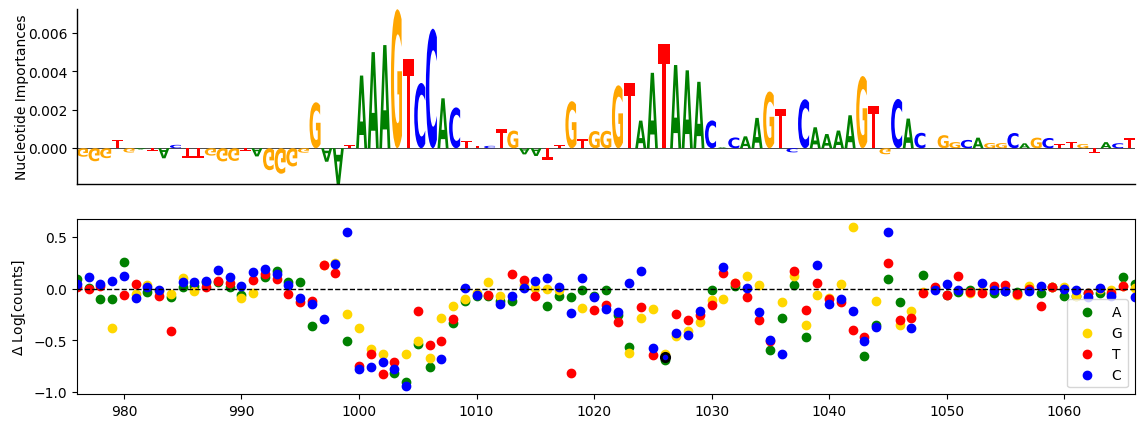

In [130]:
plot_region_ISM(seq_df_trimmed, ISM_df_trimmed,highlight_SNP=highlight_SNP,save_path="region_plots/enterocytes_AIG_regions_0_trimmed_5_withISM.pdf")

In [132]:
min_pos

976

In [134]:
143118405+1060

143119465

In [131]:
regions_df['int_start']

0    143118405.0
Name: int_start, dtype: float64

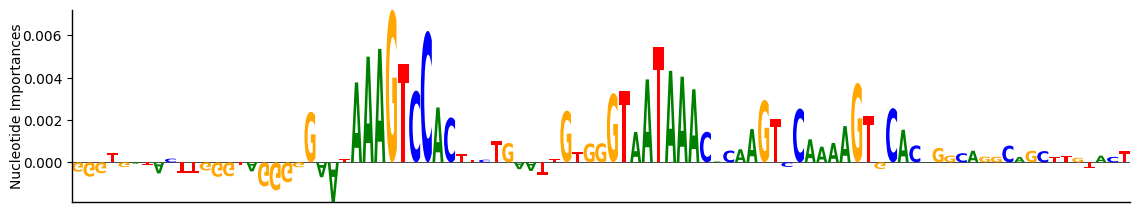

In [13]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [14]:
seq_df

,A,C,G,T
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
2109,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0
2111,0.0,0.0,0.0,0.0
2112,0.0,0.0,0.0,0.0


In [15]:
ISM_df = pd.read_csv("AIG_ISM_study_effects_wcounts.tsv",sep="\t",index_col=0)

In [31]:
ISM_df_trimmed = ISM_df.loc[ISM_df['pos']<=max_pos]
ISM_df_trimmed = ISM_df_trimmed.loc[ISM_df_trimmed['pos']>=min_pos]


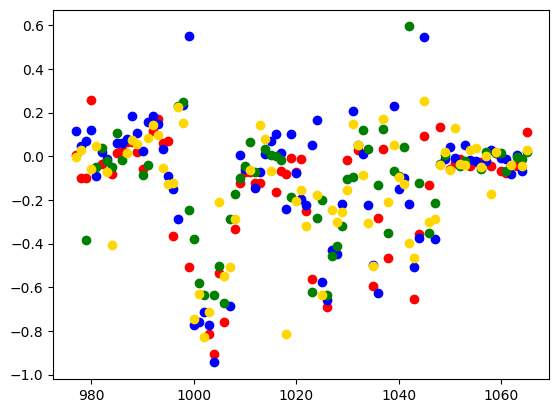

In [23]:
for base in ['A','C','G','T']:
    df_base = ISM_df_trimmed.loc[ISM_df_trimmed['alt']==base].copy()

    x,y = df_base['pos'],df_base['log_counts_diff_avg']

    if base=='A':
        plt.plot(x,y,'o',c='r')
    if base=='C':
        plt.plot(x,y,'o',c='b')
    if base=='G':
        plt.plot(x,y,'o',c='g')
    if base=='T':
        plt.plot(x,y,'o',c='gold')
plt.show()
plt.close()

In [ ]:
# create Logo object
import logomaker

crp_logo = logomaker.Logo(seq_df_trimmed,figsize=(100/2000*len(seq_df_trimmed.index)*3, 2.5),
                          shade_below=0,
                          fade_below=0)

# style using Logo methods
crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
#crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)
crp_logo.ax.set_xticks([])

# style using Axes methods
crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)
#plt.xticks(ticks=tick_locations,labels = rounded_grid2)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.png",dpi=350,bbox_inches='tight',pad_inches=0)
plt.savefig("region_plots/"+celltype+"_"+region_name+"_"+str(sequence_number)+"_trimmed_5.pdf",dpi=350,bbox_inches='tight',pad_inches=0)

plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import logomaker
import numpy as np

# Assuming len_seq and celltypes are defined
len_seq = 2000
celltypes = ['enterocytes','EEC','Goblet_cell','Stem_cell']

# Create a figure
fig = plt.figure(figsize=(300/2000*len_seq, 2.5*len(celltypes)))

# Create a GridSpec with 1 column and rows equal to the number of cell types
gs = gridspec.GridSpec(len(celltypes), 1, figure=fig)

# Create axes in each grid cell with shared y-axis
axes = [fig.add_subplot(gs[i, 0]) for i in range(len(celltypes))]

# Plot each cell type
for ax, celltype in zip(axes, celltypes):
    ax.set_title(celltype)
    model_score_avg = model_scores_celltypes[celltype].copy()
    seq_df = model_score_avg.T
    seq_df.columns = ['A','C','G','T']
    
    # Create Logo object
    crp_logo = logomaker.Logo(seq_df, figsize=(300/2000*len_seq, 2.5), shade_below=0, fade_below=0, ax=ax)
    
    # Style using Logo methods
    crp_logo.style_spines(visible=False)
    crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
    crp_logo.ax.set_xticks([])  # Remove xticks from logomaker object
    
    # Style using Axes methods
    crp_logo.ax.set_ylabel("Nucleotide Importances", labelpad=-1)
    crp_logo.ax.xaxis.set_ticks_position('none')
    crp_logo.ax.xaxis.set_tick_params(pad=-1)
    ax.set_xticks(ticks=tick_locations)
    ax.set_xticklabels(rounded_grid2)

# Set shared y-axis limits (workaround, sharey does not work with logomaker)
y_min, y_max = np.min([ax.get_ylim()[0] for ax in axes]), np.max([ax.get_ylim()[1] for ax in axes])
for ax in axes:
    ax.set_ylim(y_min, y_max)

# Display the plot
plt.tight_layout()
plt.savefig("region_plots/multi_celltypes/"+region_name+"_"+str(sequence_number)+".pdf",bbox_inches='tight',pad_inches=0)
plt.show()
